# Classifier V1

Idea now: Use pytorch's image encoders and feature extraction

https://pytorch.org/vision/stable/io.html#images

https://pytorch.org/vision/stable/feature_extraction.html



implemented from:
https://medium.com/howtoai/video-classification-with-cnn-rnn-and-pytorch-abe2f9ee031

https://github.com/PacktPublishing/PyTorch-Computer-Vision-Cookbook/blob/master/Chapter10/myutils.py



To do:

*   Try different models
*   Create second mediapipe stream
*   Use CorpusNGT Data as well once received



from google.colab import drive
drive.mount('/content/drive')

In [236]:
import os
import shutil
import pandas as pd
import numpy as np
from numpy import asarray
import cv2 as cv
import re
import math
from subprocess import check_call, PIPE, Popen
import shlex

import torchvision.transforms as transforms
from PIL import Image
import torch
from torchvision import models
from torch import nn

Take a look at the categories


In [269]:
path2data = "Data/CorpusNGT/gloss_split/"

listOfCategories = os.listdir(path2data)
listOfCategories, len(listOfCategories)

(['0',
  '1',
  '10',
  '100',
  '1000',
  '11',
  '12',
  '13',
  '14',
  '15',
  '158',
  '16',
  '17',
  '18',
  '19',
  '2',
  '2-ORD',
  '20',
  '22',
  '26',
  '3',
  '3-ORD',
  '30',
  '4',
  '4-ORD',
  '40',
  '5',
  '50',
  '500',
  '500^',
  '6',
  '60',
  '7',
  '70',
  '7UP',
  '8',
  '80',
  '9',
  '90',
  'A',
  'AAL',
  'AAN',
  'AANBELLEN',
  'AANBIEDEN',
  'AANDACHT',
  'AANHALINGSTEKENS',
  'AANKLEDEN',
  'AANKLIKKEN',
  'AANKLOPPEN',
  'AANLEUNEN',
  'AANMOEDIGEN',
  'AANPAKKEN',
  'AANPASSEN',
  'AANRANDEN',
  'AANSLUITEN',
  'AANVALLEN',
  'AANVALLEN-TEAMS',
  'AANWEZIG',
  'AAP',
  'AAPACHTIGEBEWEGINGENMAKEN',
  'AAPNADOEN',
  'AARDIG',
  'ABBEE-LEPEE',
  'ABORTUS',
  'ABORTUS-B',
  'ABTS',
  'ABWZ',
  'ACCENT',
  'ACCEPTEREN',
  'ACCORDEON',
  'ACHTER',
  'ACHTERUITGANG',
  'ADDA',
  'ADEM-INHOUDEN',
  'ADEMEN',
  'ADOLFITLER',
  'ADVIES',
  'AF',
  'AFBLIJVEN',
  'AFHANKELIJK',
  'AFHOUDEN',
  'AFKEUREN',
  'AFPAKKEN',
  'AFRIKA',
  'AFRONDEN',
  'AFSCHEIDEN',
 

In [270]:
for cat in listOfCategories:
    print("category:", cat)
    path2acat = os.path.join(path2data, cat)
    listOfSubs = os.listdir(path2acat)
    print("number of sub-folders:", len(listOfSubs))

category: 0
number of sub-folders: 74
category: 1
number of sub-folders: 1042
category: 10
number of sub-folders: 96
category: 100
number of sub-folders: 70
category: 1000
number of sub-folders: 38
category: 11
number of sub-folders: 40
category: 12
number of sub-folders: 44
category: 13
number of sub-folders: 26
category: 14
number of sub-folders: 24
category: 15
number of sub-folders: 38
category: 158
number of sub-folders: 2
category: 16
number of sub-folders: 8
category: 17
number of sub-folders: 12
category: 18
number of sub-folders: 18
category: 19
number of sub-folders: 26
category: 2
number of sub-folders: 450
category: 2-ORD
number of sub-folders: 64
category: 20
number of sub-folders: 62
category: 22
number of sub-folders: 10
category: 26
number of sub-folders: 4
category: 3
number of sub-folders: 174
category: 3-ORD
number of sub-folders: 20
category: 30
number of sub-folders: 22
category: 4
number of sub-folders: 126
category: 4-ORD
number of sub-folders: 2
category: 40
num

In [271]:
unique_glosses = np.load('Data/CorpusNGT/gloss_labels.npy',allow_pickle='TRUE').item()
#gloss_counter = np.load('Data/CorpusNGT/gloss_counts.npy',allow_pickle='TRUE').item()
print(unique_glosses)

{'GLOSS': 0, 'LANG': 1, 'PO': 2, 'ZONDAG': 3, 'FIETSEN': 4, 'LOPEN': 5, 'WATER': 6, 'SPRINGEN': 7, 'STAAN': 8, 'BEEN': 9, 'GEK': 10, 'HOND': 11, 'DUWEN': 12, 'MOVE': 13, 'MEE': 14, 'GOOIEN': 15, 'KLAAR': 16, 'KLEREN': 17, 'VOCHTIG': 18, 'LACHEN': 19, 'UITKLEDEN': 20, 'VAN': 21, 'BROEK': 22, 'AANKLEDEN': 23, 'AL': 24, 'WACHTEN': 25, 'DROOG': 26, 'WEG': 27, 'BROOD': 28, 'JAM': 29, 'ONDERWIJS': 30, 'INTERNAAT': 31, 'ONGESTELD': 32, 'VERSCHILLENDE': 33, 'DUS': 34, 'ZENUWACHTIG': 35, 'OPGELUCHT': 36, 'BETER': 37, 'VERSLAAN': 38, 'GOED': 39, 'PANTOFFELS': 40, 'BE': 41, 'UUR': 42, 'BINNEN': 43, 'MOETEN': 44, 'LAATSTE': 45, 'PT': 46, 'MOOI': 47, 'HANDEN-WRIJVEN': 48, 'SCHRIKKEN': 49, 'SCHREEUWEN': 50, 'VLUCHTEN': 51, 'KAPOT': 52, 'HOUDEN-VAN': 53, 'SCHOOL': 54, 'ZATERDAG': 55, 'KAART': 56, 'BEZOEK': 57, 'TREIN': 58, 'BRIEF': 59, 'KUNNEN': 60, 'WAAR': 61, 'OPEN': 62, 'GEZELLIG': 63, 'PRATEN': 64, 'VERHAAL': 65, 'PRECIES': 66, 'KERK': 67, 'WIJ': 68, 'GAAN': 69, 'S': 70, 'MOEDER': 71, 'RUIMTE': 7

## 1 SPLIT INTO TEST AND TRAINING SETS

In [374]:
def get_vids(path2data):
    listOfCats = os.listdir(path2data)
    ids = []
    labels = []
    usableListOfCats = []
    for catg in listOfCats:
        path2catg = os.path.join(path2data, catg)
        counter = 0
        if len(os.listdir(path2catg)) > 10:  # We can only use glosses which have more than 1 occurence, meaning more than 2 files in dir, since video and frames are in there.
            counter += 1
            listOfSubCats = os.listdir(path2catg)
            path2subCats = [os.path.join(path2catg, los) for los in listOfSubCats if os.path.isdir(os.path.join(path2catg, los))]
            #print(path2subCats)
            ids.extend(path2subCats)
            labels.extend([catg]*len(path2subCats))
            usableListOfCats.append(catg)
    return ids, labels, usableListOfCats

In [375]:
all_vids, all_labels, catgs = get_vids(path2data)
len(all_vids), len(all_labels), len(catgs)

(114815, 114815, 1146)

We have around 1146 classes with more than 5 datapoints in them and about 114815 datapoints total. So an average of 100 instances per class. With the instances per class ranging from 10 to over 500.

In [331]:
labels_dict = {}
ind = 0
for uc in catgs:
    labels_dict[uc] = ind
    ind+=1
labels_dict

{'0': 0,
 '1': 1,
 '10': 2,
 '100': 3,
 '1000': 4,
 '11': 5,
 '12': 6,
 '13': 7,
 '14': 8,
 '15': 9,
 '16': 10,
 '17': 11,
 '18': 12,
 '19': 13,
 '2': 14,
 '2-ORD': 15,
 '20': 16,
 '22': 17,
 '26': 18,
 '3': 19,
 '3-ORD': 20,
 '30': 21,
 '4': 22,
 '40': 23,
 '5': 24,
 '50': 25,
 '500': 26,
 '500^': 27,
 '6': 28,
 '60': 29,
 '7': 30,
 '70': 31,
 '7UP': 32,
 '8': 33,
 '80': 34,
 '9': 35,
 '90': 36,
 'A': 37,
 'AAN': 38,
 'AANBELLEN': 39,
 'AANBIEDEN': 40,
 'AANDACHT': 41,
 'AANHALINGSTEKENS': 42,
 'AANKLEDEN': 43,
 'AANKLIKKEN': 44,
 'AANKLOPPEN': 45,
 'AANMOEDIGEN': 46,
 'AANPAKKEN': 47,
 'AANPASSEN': 48,
 'AANRANDEN': 49,
 'AANSLUITEN': 50,
 'AANVALLEN': 51,
 'AANVALLEN-TEAMS': 52,
 'AANWEZIG': 53,
 'AAP': 54,
 'AAPACHTIGEBEWEGINGENMAKEN': 55,
 'AAPNADOEN': 56,
 'ABBEE-LEPEE': 57,
 'ABORTUS': 58,
 'ABORTUS-B': 59,
 'ACCENT': 60,
 'ACCEPTEREN': 61,
 'ACCORDEON': 62,
 'ACHTER': 63,
 'ADEM-INHOUDEN': 64,
 'ADEMEN': 65,
 'ADVIES': 66,
 'AF': 67,
 'AFBLIJVEN': 68,
 'AFHANKELIJK': 69,
 'AFKE

In [332]:
num_classes = len(catgs)
unique_ids = [id_ for id_, label in zip(all_vids,all_labels) if labels_dict[label]<num_classes]
unique_labels = [label for id_, label in zip(all_vids,all_labels) if labels_dict[label]<num_classes]
len(unique_ids), len(unique_labels)
#print(unique_ids)
#print(unique_labels)

(116773, 116773)

In [333]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=0)
train_indx, test_indx = next(sss.split(unique_ids, unique_labels))

train_ids = [unique_ids[ind] for ind in train_indx]
train_labels = [unique_labels[ind] for ind in train_indx]
print(len(train_ids), len(train_labels))

test_ids = [unique_ids[ind] for ind in test_indx]
test_labels = [unique_labels[ind] for ind in test_indx]
print(len(test_ids), len(test_labels))

105095 105095
11678 11678


In [279]:
# We've now obtained the paths and labels for all sets of gloss frames that have two or more occurrences of the gloss, and split these into a test and training set

## 2 DEFINE DATASETS AND TRANSFORMS

In [334]:
# Now we have to transform the frames into usable format; tensors

In [335]:
from torch.utils.data import Dataset, DataLoader, Subset
import glob
from PIL import Image
import torch
import numpy as np
import random
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt

np.random.seed(2024)
random.seed(2024)
torch.manual_seed(2024)

In [336]:
# Choose model type, this is just a test. For now we pick the R3D_18 ResNet 18 layer model from pytorch that has been pretrained on the Kinetics dataset
model_type = "R3D_18"
#model_type = "rnn"

timesteps = 6
if model_type == "rnn":
    h, w =224, 224
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
else:
    h, w = 112, 112
    mean = [0.43216, 0.394666, 0.37645]
    std = [0.22803, 0.22145, 0.216989]

In [346]:
class VideoDataset(Dataset):
    def __init__(self, ids, labels, transform):
        self.transform = transform
        self.ids = ids
        self.labels = labels
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        path2imgs=glob.glob(self.ids[idx]+"/*.jpg")
        path2imgs = path2imgs[:timesteps]
        label = labels_dict[self.labels[idx]]
        frames = []
        for p2i in path2imgs:
            frame = Image.open(p2i)
            frames.append(frame)

        seed = np.random.randint(1e9)
        frames_tr = []
        for frame in frames:
            random.seed(seed)
            np.random.seed(seed)
            frame = self.transform(frame)
            frames_tr.append(frame)
        if len(frames_tr)>0:
            frames_tr = torch.stack(frames_tr)
        return frames_tr, label

In [367]:
class KeyPointDataset(Dataset):
    def __init__(self, ids, labels, transform):
        self.transform = transform
        self.ids = ids
        self.labels = labels
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        path2keypoints=glob.glob(self.ids[idx]+"/*.npy")
        path2keypoints = path2keypoints[:timesteps]
        label = labels_dict[self.labels[idx]]
        frames = []
        for p2i in path2keypoints:
            frame = np.load(p2i)
            frames.append(frame)

        seed = np.random.randint(1e9)
        frames_tr = []
        for frame in frames:
            random.seed(seed)
            np.random.seed(seed)
            frames_tr.append(torch.from_numpy(frame))
        if len(frames_tr)>0:
            frames_tr = torch.stack(frames_tr)
        return frames_tr, label

In [368]:
# define helper functions

def transform_frames(frames, model_type="rnn"):
    if model_type == "rnn":
        h, w = 224, 224
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    else:
        h, w = 112, 112
        mean = [0.43216, 0.394666, 0.37645]
        std = [0.22803, 0.22145, 0.216989]

    test_transformer = transforms.Compose([
                transforms.Resize((h,w)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)])

    frames_tr = []
    for frame in frames:
        frame = Image.fromarray(frame)
        frame_tr = test_transformer(frame)
        frames_tr.append(frame_tr)
    imgs_tensor = torch.stack(frames_tr)

    if model_type != "rnn":
        imgs_tensor = torch.transpose(imgs_tensor, 1, 0)
    imgs_tensor = imgs_tensor.unsqueeze(0)
    return imgs_tensor

def transform_keypoint_frames(frames, model_type="rnn"):
    if model_type == "rnn":
        h, w = 33, 3
    else:
        h, w = 33, 3
        # already normalized by mp

    test_transformer = transforms.Compose([
                torch.from_numpy()]
        )

    frames_tr = []
    for frame in frames:
        frame = frame
        frame_tr = test_transformer(frame)
        frames_tr.append(frame_tr)
    imgs_tensor = torch.stack(frames_tr)

    return imgs_tensor

def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = to_pil_image(x)
    return x

TRAIN

In [369]:
train_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])

train_transformer_keypoints = transforms.Compose([
            transforms.ToTensor()
            ])

#train_ds = VideoDataset(ids= train_ids, labels= train_labels, transform= train_transformer)
#print(len(train_ds))

train_ds = KeyPointDataset(ids= train_ids, labels= train_labels, transform= train_transformer)
print(len(train_ds))

105095


In [370]:
# inspect
imgs, label = train_ds[10]
imgs.shape, label, torch.min(imgs), torch.max(imgs)

(torch.Size([2, 33, 3]),
 91,
 tensor(-0.8971, dtype=torch.float64),
 tensor(1.8081, dtype=torch.float64))

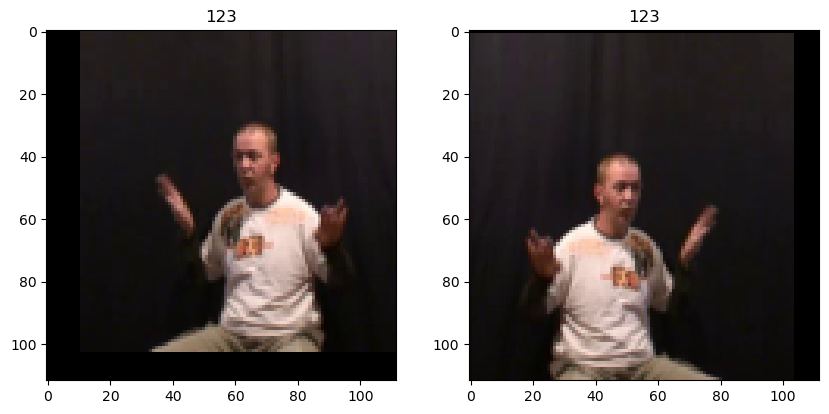

In [287]:
%matplotlib inline

## For image condition, not keypoints

plt.figure(figsize=(10,10))
for ii,img in enumerate(imgs[::2]):
    plt.subplot(2,2,ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.title(label)

TEST

In [371]:
test_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])

test_transformer_keypoints = transforms.Compose([
            transforms.ToTensor()
            ])

#test_ds = VideoDataset(ids= test_ids, labels= test_labels, transform= test_transformer)
#print(len(test_ds))

test_ds = KeyPointDataset(ids= train_ids, labels= train_labels, transform= train_transformer)
print(len(train_ds))

105095


In [372]:
imgs, label = test_ds[5]
imgs.shape, label, torch.min(imgs), torch.max(imgs)

AttributeError: 'list' object has no attribute 'shape'

In [373]:
plt.figure(figsize=(10,10))
for ii,img in enumerate(imgs[::2]):
    plt.subplot(2,2,ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.title(label)

<Figure size 1000x1000 with 0 Axes>

## 3 DEFINE DATALOADER

We define the custom dataloader for our model; batch and stack the images etc

In [291]:
def collate_fn_r3d_18(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    imgs_tensor = torch.transpose(imgs_tensor, 2, 1)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor

def collate_fn_rnn(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor


batch_size = 1
if model_type == "rnn":
    train_dl = DataLoader(train_ds, batch_size= batch_size,
                          shuffle=True, collate_fn= collate_fn_rnn)
    test_dl = DataLoader(test_ds, batch_size= 2*batch_size,
                         shuffle=False, collate_fn= collate_fn_rnn)
else:
    train_dl = DataLoader(train_ds, batch_size= batch_size,
                          shuffle=True, collate_fn= collate_fn_r3d_18)
    test_dl = DataLoader(test_ds, batch_size= 2*batch_size,
                         shuffle=False, collate_fn= collate_fn_r3d_18)

In [292]:
for xb,yb in train_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([1, 3, 3, 112, 112]) torch.Size([1])


In [293]:
for xb,yb in test_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([2, 3, 6, 112, 112]) torch.Size([2])


## 4 DEFINE MODEL

In [294]:
class Resnt18Rnn(nn.Module):
    def __init__(self, params_model):
        super(Resnt18Rnn, self).__init__()
        num_classes = params_model["num_classes"]
        dr_rate= params_model["dr_rate"]
        pretrained = params_model["pretrained"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]

        baseModel = models.r3d_18(pretrained=pretrained)
        num_features = baseModel.fc.in_features
        baseModel.fc = Identity()
        self.baseModel = baseModel
        self.dropout= nn.Dropout(dr_rate)
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
    def forward(self, x):
        b_z, ts, c, h, w = x.shape
        ii = 0
        y = self.baseModel((x[:,ii]))
        output, (hn, cn) = self.rnn(y.unsqueeze(1))
        for ii in range(1, ts):
            y = self.baseModel((x[:,ii]))
            out, (hn, cn) = self.rnn(y.unsqueeze(1), (hn, cn))
        out = self.dropout(out[:,-1])
        out = self.fc1(out)
        return out

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

In [295]:
if model_type == "rnn":
    params_model={
        "num_classes": num_classes,
        "dr_rate": 0.1,
        "pretrained" : True,
        "rnn_num_layers": 1,
        "rnn_hidden_size": 100,}
    model = Resnt18Rnn(params_model)
else:
    model = models.video.r3d_18(weights='KINETICS400_V1', progress=False)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)

In [296]:
with torch.no_grad():
    if model_type=="rnn":
        x = torch.zeros(1, 8, 3, h, w)
    else:
        x = torch.zeros(1, 3, 8, h, w)
    y= model(x)
    print(y.shape)

torch.Size([1, 171])


In [297]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [298]:
model

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [299]:
path2weights = "Models/weights.pt"
torch.save(model.state_dict(), path2weights)

## 5 TRAIN MODEL

## TO DO: PRETRAINING

In [300]:
import copy
import tqdm

def plot_loss(loss_hist, metric_hist):

    num_epochs= len(loss_hist["train"])

    plt.title("Train-Val Loss")
    plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
    plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
    plt.ylabel("Loss")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

    plt.title("Train-Val Accuracy")
    plt.plot(range(1,num_epochs+1), metric_hist["train"],label="train")
    plt.plot(range(1,num_epochs+1), metric_hist["val"],label="val")
    plt.ylabel("Accuracy")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()


def metrics_batch(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    with torch.no_grad():
        metric_b = metrics_batch(output,target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b

def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data = len(dataset_dl.dataset)
    for xb, yb in tqdm.notebook.tqdm(dataset_dl):
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb)
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        running_loss+=loss_b

        # GET ACCURACY
        if metric_b is not None:
            running_metric+=metric_b

        if sanity_check is True:
            break

   #     _, preds = torch.max(output.data, 1)
   #     running_metric += (preds == yb).float().sum()
   #     print(running_metric)
   # metric = running_metric/float(len_data)
   # print(metric)

    loss=running_loss/float(len_data)
    metric=running_metric/float(len_data)
    return loss, metric

def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history={
        "train": [],
        "val": [],
    }

    metric_history={
        "train": [],
        "val": [],
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')

    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl,sanity_check)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights")

        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights")
            model.load_state_dict(best_model_wts)


        print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f" %(train_loss,val_loss,100*val_metric))
        print("-"*10)
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [303]:
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

loss_func = nn.CrossEntropyLoss(reduction="mean")   # our current loss function is Cross Entropy Loss or CTC Loss.   nn.CrossEntropyLoss(reduction="sum") -->    nn.CTCLoss(reduction="mean")
opt = optim.Adam(model.parameters(), lr=1e-3)       # original lr=3e-5 in baseline paper lr=1e-3. Baseline also uses adam with batch size of 8 and weight decay of 1e-3.
#lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=5, verbose=True)    # patientce is 5, so after 5 epochs of no improvement learning rate is lr*factor, so halved
lr_scheduler = CosineAnnealingLR(opt, T_max=50)     # maximum amount of iterations on the lr
os.makedirs("Thesis/Models", exist_ok=True)

params_train={
    "num_epochs": 80,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": test_dl,
    "sanity_check": True,
    "lr_scheduler": lr_scheduler,
    "path2weights": "Models/weights_"+model_type+".pt",
    }
model,loss_hist,metric_hist = train_val(model,params_train)

Epoch 0/79, current lr=0.001


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Copied best model weights
Loading best model weights
train loss: 0.000098, dev loss: 0.020898, accuracy: 0.00
----------
Epoch 1/79, current lr=0.0009999995689657635


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000085, dev loss: 0.024057, accuracy: 0.00
----------
Epoch 2/79, current lr=0.0009999994288000184


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000081, dev loss: 0.033623, accuracy: 0.00
----------
Epoch 3/79, current lr=0.0009999988842590572


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000081, dev loss: 0.029757, accuracy: 0.00
----------
Epoch 4/79, current lr=0.0009999991260416627


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000081, dev loss: 0.032463, accuracy: 0.00
----------
Epoch 5/79, current lr=0.0009999989598788019


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Copied best model weights
Loading best model weights
train loss: 0.000089, dev loss: 0.014345, accuracy: 0.00
----------
Epoch 6/79, current lr=0.00099999979689771


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Copied best model weights
Loading best model weights
train loss: 0.000069, dev loss: 0.009977, accuracy: 0.00
----------
Epoch 7/79, current lr=0.000999999901765969


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Copied best model weights
Loading best model weights
train loss: 0.000067, dev loss: 0.006653, accuracy: 0.00
----------
Epoch 8/79, current lr=0.0009999999563129473


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Copied best model weights
Loading best model weights
train loss: 0.000067, dev loss: 0.004835, accuracy: 0.00
----------
Epoch 9/79, current lr=0.0009999999769314352


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Copied best model weights
Loading best model weights
train loss: 0.000077, dev loss: 0.004446, accuracy: 0.00
----------
Epoch 10/79, current lr=0.000999999980493896


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Copied best model weights
Loading best model weights
train loss: 0.000048, dev loss: 0.003374, accuracy: 0.00
----------
Epoch 11/79, current lr=0.0009999999887655795


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Copied best model weights
Loading best model weights
train loss: 0.000074, dev loss: 0.002157, accuracy: 0.00
----------
Epoch 12/79, current lr=0.0009999999954092313


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000081, dev loss: 0.007386, accuracy: 0.00
----------
Epoch 13/79, current lr=0.0009999999461552168


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000084, dev loss: 0.004701, accuracy: 0.00
----------
Epoch 14/79, current lr=0.000999999978185943


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000035, dev loss: 0.002772, accuracy: 0.00
----------
Epoch 15/79, current lr=0.0009999999924147995


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000076, dev loss: 0.003418, accuracy: 0.00
----------
Epoch 16/79, current lr=0.0009999999884682648


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000084, dev loss: 0.002371, accuracy: 0.00
----------
Epoch 17/79, current lr=0.000999999994453724


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000071, dev loss: 0.003591, accuracy: 0.00
----------
Epoch 18/79, current lr=0.0009999999872722166


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000078, dev loss: 0.002527, accuracy: 0.00
----------
Epoch 19/79, current lr=0.000999999993695953


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000078, dev loss: 0.002706, accuracy: 0.00
----------
Epoch 20/79, current lr=0.0009999999927711627


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Copied best model weights
Loading best model weights
train loss: 0.000079, dev loss: 0.002134, accuracy: 0.00
----------
Epoch 21/79, current lr=0.0009999999955073607


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000076, dev loss: 0.002430, accuracy: 0.00
----------
Epoch 22/79, current lr=0.0009999999941709265


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000076, dev loss: 0.002496, accuracy: 0.00
----------
Epoch 23/79, current lr=0.0009999999938503897


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Copied best model weights
Loading best model weights
train loss: 0.000079, dev loss: 0.002105, accuracy: 0.00
----------
Epoch 24/79, current lr=0.0009999999956275796


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000084, dev loss: 0.002915, accuracy: 0.00
----------
Epoch 25/79, current lr=0.0009999999916147262


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000082, dev loss: 0.002449, accuracy: 0.00
----------
Epoch 26/79, current lr=0.0009999999940795209


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000079, dev loss: 0.002193, accuracy: 0.00
----------
Epoch 27/79, current lr=0.0009999999952536342


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000040, dev loss: 0.002318, accuracy: 0.00
----------
Epoch 28/79, current lr=0.0009999999946967405


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Copied best model weights
Loading best model weights
train loss: 0.000081, dev loss: 0.001905, accuracy: 0.00
----------
Epoch 29/79, current lr=0.0009999999964192432


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Copied best model weights
Loading best model weights
train loss: 0.000082, dev loss: 0.001717, accuracy: 0.00
----------
Epoch 30/79, current lr=0.0009999999970896757


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Copied best model weights
Loading best model weights
train loss: 0.000077, dev loss: 0.001282, accuracy: 0.00
----------
Epoch 31/79, current lr=0.0009999999983767707


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000080, dev loss: 0.001359, accuracy: 0.00
----------
Epoch 32/79, current lr=0.0009999999981770101


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000061, dev loss: 0.001467, accuracy: 0.00
----------
Epoch 33/79, current lr=0.000999999997876803


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Copied best model weights
Loading best model weights
train loss: 0.000079, dev loss: 0.001038, accuracy: 0.00
----------
Epoch 34/79, current lr=0.0009999999989375806


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Copied best model weights
Loading best model weights
train loss: 0.000029, dev loss: 0.001025, accuracy: 0.00
----------
Epoch 35/79, current lr=0.0009999999989638185


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Copied best model weights
Loading best model weights
train loss: 0.000032, dev loss: 0.000722, accuracy: 0.00
----------
Epoch 36/79, current lr=0.0009999999994860815


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Copied best model weights
Loading best model weights
train loss: 0.000085, dev loss: 0.000597, accuracy: 0.00
----------
Epoch 37/79, current lr=0.0009999999996479756


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Copied best model weights
Loading best model weights
train loss: 0.000031, dev loss: 0.000513, accuracy: 0.00
----------
Epoch 38/79, current lr=0.0009999999997403867


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Copied best model weights
Loading best model weights
train loss: 0.000096, dev loss: 0.000494, accuracy: 0.00
----------
Epoch 39/79, current lr=0.000999999999759609


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Copied best model weights
Loading best model weights
train loss: 0.000093, dev loss: 0.000443, accuracy: 0.00
----------
Epoch 40/79, current lr=0.0009999999998066365


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000061, dev loss: 0.000521, accuracy: 0.01
----------
Epoch 41/79, current lr=0.0009999999997322123


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000026, dev loss: 0.000522, accuracy: 0.01
----------
Epoch 42/79, current lr=0.0009999999997313313


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000102, dev loss: 0.000521, accuracy: 0.00
----------
Epoch 43/79, current lr=0.0009999999997316181


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000052, dev loss: 0.000522, accuracy: 0.00
----------
Epoch 44/79, current lr=0.0009999999997313963


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000096, dev loss: 0.000522, accuracy: 0.01
----------
Epoch 45/79, current lr=0.0009999999997312183


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000026, dev loss: 0.000502, accuracy: 0.00
----------
Epoch 46/79, current lr=0.0009999999997515622


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000029, dev loss: 0.000490, accuracy: 0.00
----------
Epoch 47/79, current lr=0.0009999999997629106


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000050, dev loss: 0.000482, accuracy: 0.00
----------
Epoch 48/79, current lr=0.000999999999771002


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000063, dev loss: 0.000500, accuracy: 0.00
----------
Epoch 49/79, current lr=0.0009999999997533243


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000027, dev loss: 0.000497, accuracy: 0.00
----------
Epoch 50/79, current lr=0.0009999999997558071


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000096, dev loss: 0.000479, accuracy: 0.00
----------
Epoch 51/79, current lr=0.0009999999997735121


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000059, dev loss: 0.000454, accuracy: 0.00
----------
Epoch 52/79, current lr=0.000999999999796292


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000059, dev loss: 0.000459, accuracy: 0.00
----------
Epoch 53/79, current lr=0.0009999999997924087


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000092, dev loss: 0.000512, accuracy: 0.00
----------
Epoch 54/79, current lr=0.0009999999997416143


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000060, dev loss: 0.000522, accuracy: 0.00
----------
Epoch 55/79, current lr=0.0009999999997309997


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000027, dev loss: 0.000508, accuracy: 0.00
----------
Epoch 56/79, current lr=0.0009999999997454868


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000093, dev loss: 0.000517, accuracy: 0.00
----------
Epoch 57/79, current lr=0.0009999999997365198


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000074, dev loss: 0.000483, accuracy: 0.00
----------
Epoch 58/79, current lr=0.0009999999997697573


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000098, dev loss: 0.000508, accuracy: 0.00
----------
Epoch 59/79, current lr=0.0009999999997456282


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000095, dev loss: 0.000496, accuracy: 0.00
----------
Epoch 60/79, current lr=0.0009999999997567176


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000096, dev loss: 0.000466, accuracy: 0.00
----------
Epoch 61/79, current lr=0.0009999999997857927


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000097, dev loss: 0.000459, accuracy: 0.00
----------
Epoch 62/79, current lr=0.0009999999997920526


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000026, dev loss: 0.000497, accuracy: 0.00
----------
Epoch 63/79, current lr=0.0009999999997565635


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000099, dev loss: 0.000473, accuracy: 0.00
----------
Epoch 64/79, current lr=0.00099999999977961


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000026, dev loss: 0.000501, accuracy: 0.00
----------
Epoch 65/79, current lr=0.0009999999997521646


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000099, dev loss: 0.000466, accuracy: 0.00
----------
Epoch 66/79, current lr=0.0009999999997855457


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000027, dev loss: 0.000470, accuracy: 0.00
----------
Epoch 67/79, current lr=0.0009999999997819804


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000025, dev loss: 0.000471, accuracy: 0.00
----------
Epoch 68/79, current lr=0.0009999999997810643


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000025, dev loss: 0.000488, accuracy: 0.00
----------
Epoch 69/79, current lr=0.0009999999997650575


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000094, dev loss: 0.000493, accuracy: 0.00
----------
Epoch 70/79, current lr=0.0009999999997605015


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000026, dev loss: 0.000478, accuracy: 0.00
----------
Epoch 71/79, current lr=0.0009999999997745172


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000098, dev loss: 0.000466, accuracy: 0.00
----------
Epoch 72/79, current lr=0.0009999999997854282


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000027, dev loss: 0.000503, accuracy: 0.00
----------
Epoch 73/79, current lr=0.0009999999997501688


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000104, dev loss: 0.000476, accuracy: 0.00
----------
Epoch 74/79, current lr=0.0009999999997760665


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000093, dev loss: 0.000509, accuracy: 0.00
----------
Epoch 75/79, current lr=0.0009999999997439004


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000097, dev loss: 0.000522, accuracy: 0.00
----------
Epoch 76/79, current lr=0.0009999999997307779


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000026, dev loss: 0.000515, accuracy: 0.00
----------
Epoch 77/79, current lr=0.0009999999997380405


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000026, dev loss: 0.000523, accuracy: 0.00
----------
Epoch 78/79, current lr=0.000999999999730271


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000026, dev loss: 0.000523, accuracy: 0.00
----------
Epoch 79/79, current lr=0.000999999999729927


  0%|          | 0/77085 [00:00<?, ?it/s]

  0%|          | 0/4283 [00:00<?, ?it/s]

Loading best model weights
train loss: 0.000094, dev loss: 0.000519, accuracy: 0.00
----------


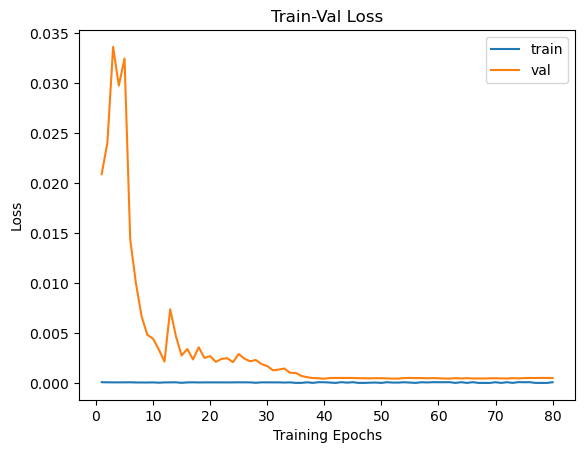

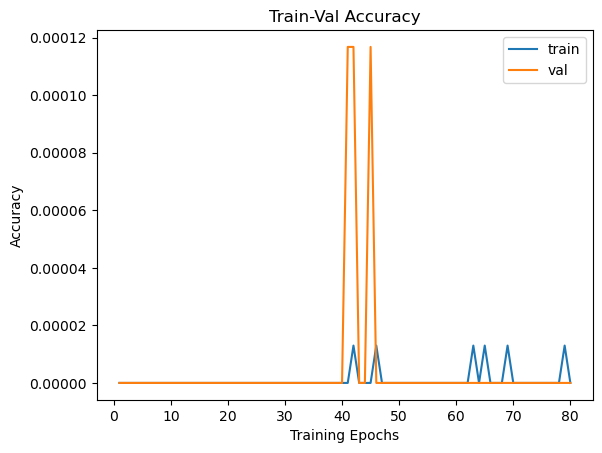

In [304]:
plot_loss(loss_hist, metric_hist)

## Loss is only marginally improving and accuracy is ~0 at every epoch meaning the model is not getting anything right? --> Not enough data yet.

## 6 TEST MODEL

In [305]:
def get_model(num_classes, model_type="rnn"):
    if model_type == "rnn":
        params_model={
            "num_classes": num_classes,
            "dr_rate": 0.1,
            "pretrained" : True,
            "rnn_num_layers": 1,
            "rnn_hidden_size": 100,}
        model = Resnt18Rnn(params_model)
    else:
        model = models.video.r3d_18(pretrained=True, progress=False)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)
    return model

def get_frames(filename, n_frames= 1):
    frames = []
    v_cap = cv.VideoCapture(filename)
    v_len = int(v_cap.get(cv.CAP_PROP_FRAME_COUNT))
    frame_list= np.linspace(0, v_len-1, n_frames+1, dtype=np.int16)

    for fn in range(v_len):
        success, frame = v_cap.read()
        if success is False:
            continue
        if (fn in frame_list):
            frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
            frames.append(frame)
    v_cap.release()
    return frames, v_len

# define helper functions

def transform_frames(frames, model_type="rnn"):
    if model_type == "rnn":
        h, w = 224, 224
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    else:
        h, w = 112, 112
        mean = [0.43216, 0.394666, 0.37645]
        std = [0.22803, 0.22145, 0.216989]

    test_transformer = transforms.Compose([
                transforms.Resize((h,w)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)])

    frames_tr = []
    for frame in frames:
        frame = Image.fromarray(frame)
        frame_tr = test_transformer(frame)
        frames_tr.append(frame_tr)
    imgs_tensor = torch.stack(frames_tr)

    if model_type != "rnn":
        imgs_tensor = torch.transpose(imgs_tensor, 1, 0)
    imgs_tensor = imgs_tensor.unsqueeze(0)
    return imgs_tensor

def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = to_pil_image(x)
    return x

In [306]:
model_type = "R3D_18"
model = get_model(model_type = model_type, num_classes = num_classes)
model.eval();

C:\Users\novan\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\novan\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [307]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

path2weights = "Models/weights_"+model_type+".pt"

model.load_state_dict(torch.load(path2weights))
model.to(device);

In [316]:
path2vido = "Data/CorpusNGT/gloss_split/GEBAREN/4.mpg"
frames, v_len = get_frames(path2vido, n_frames=8)
len(frames), v_len

(9, 28)

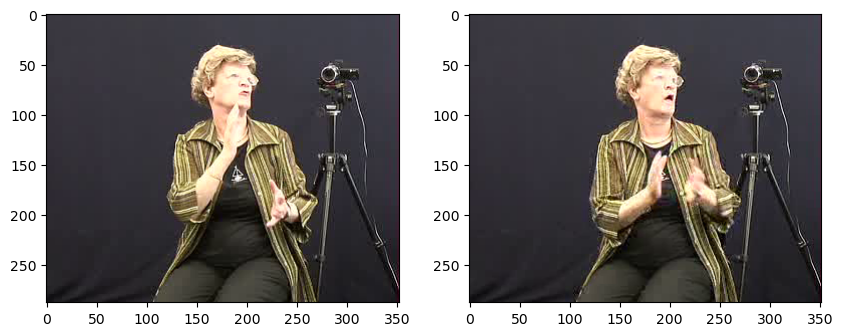

In [317]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(10,10))
for ii,img in enumerate(frames[::5]):
    plt.subplot(2,2,ii+1)
    plt.imshow(img)

In [318]:
imgs_tensor = transform_frames(frames, model_type)
print(imgs_tensor.shape, torch.min(imgs_tensor), torch.max(imgs_tensor))

torch.Size([1, 3, 9, 112, 112]) tensor(-1.7748) tensor(2.7335)


In [319]:
with torch.no_grad():
    out = model(imgs_tensor.to(device)).cpu()
    #print(out)
    pred = torch.argmax(out).item()
    print(pred)
    print(out[0][pred])
    keys = list(labels_dict.keys())
    print(keys[pred])
    print()
    print(out)

123
tensor(-6.2736)
PT

tensor([[-26.1290, -24.5552, -23.8276, -25.3083, -26.5652, -24.9390, -23.6431,
         -23.3221, -25.6474, -24.7347, -22.9749, -17.9797, -26.5715, -25.5916,
         -23.5817, -15.1029, -22.1376, -24.9301, -25.7895, -23.0234, -25.9596,
         -24.7542, -21.5850, -14.1949, -24.9987, -26.0905, -24.3160, -23.8994,
         -25.8568, -25.5841, -26.0494, -26.4750, -26.6244, -23.9612, -24.2444,
         -23.9058, -25.8911, -24.8690, -26.0328, -24.5370, -15.1308, -24.7139,
         -23.5891,  -7.3495, -23.8162, -24.2737, -24.0115, -14.3146, -25.0551,
         -11.8309, -24.6545, -19.7778, -24.1716, -23.5931, -23.2308, -13.1859,
         -24.1702, -22.6285, -25.1996, -24.5627, -25.0954, -24.5102, -24.7336,
         -25.2884, -13.4114, -22.4122, -23.3390, -25.1873, -24.6553, -23.7830,
         -24.4036, -24.8945, -22.7166, -15.4496, -15.3742, -24.6294, -12.6271,
         -25.3074, -10.7915, -25.7081, -23.7068, -23.7338, -21.5894, -24.7626,
         -25.1106, -24.1051,